<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_with_SMOTE_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 772M/786M [00:05<00:00, 161MB/s]
100% 786M/786M [00:05<00:00, 141MB/s]


In [ ]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [ ]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [ ]:
len(df.index)

2239

In [ ]:
df.head(3)

,FilePaths,Labels
0,/content/Skin cancer ISIC The International Sk...,melanoma
1,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma
2,/content/Skin cancer ISIC The International Sk...,vascular lesion


Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

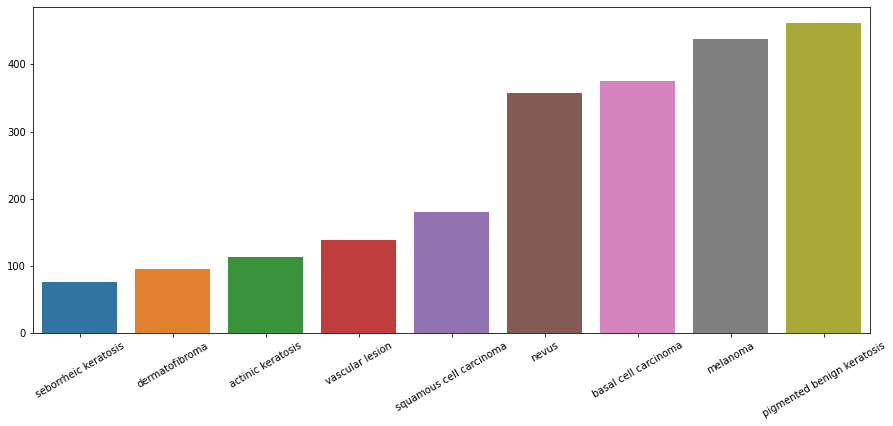

In [ ]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

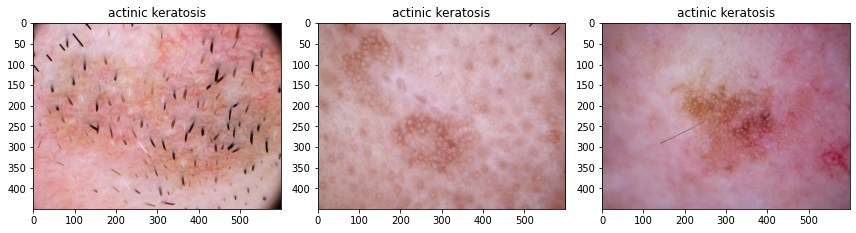

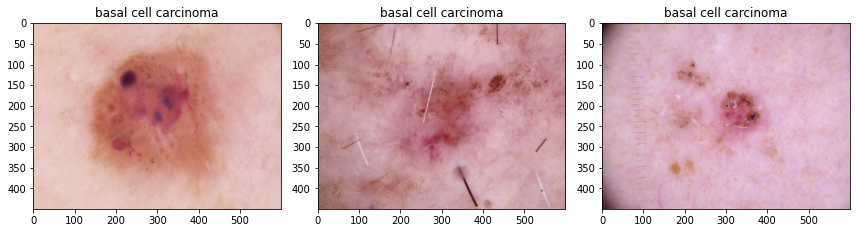

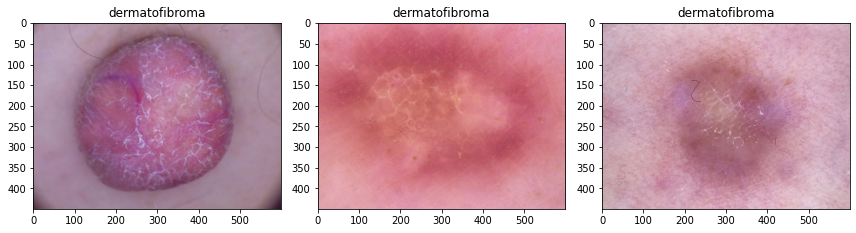

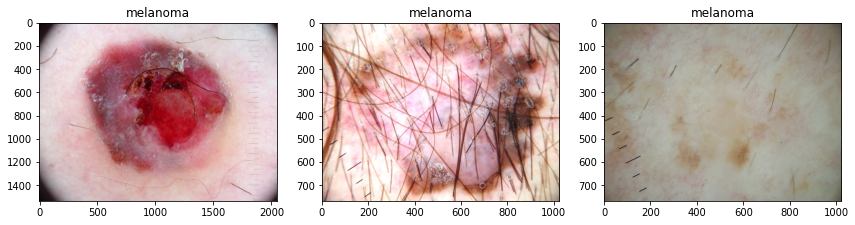

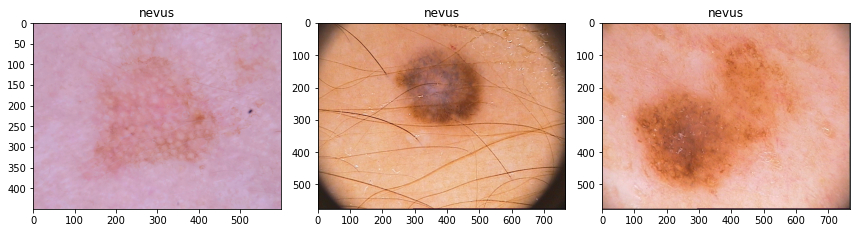

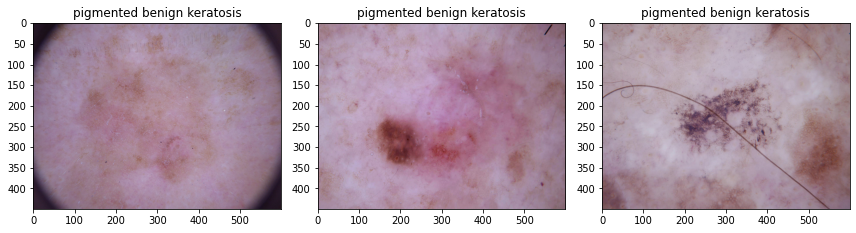

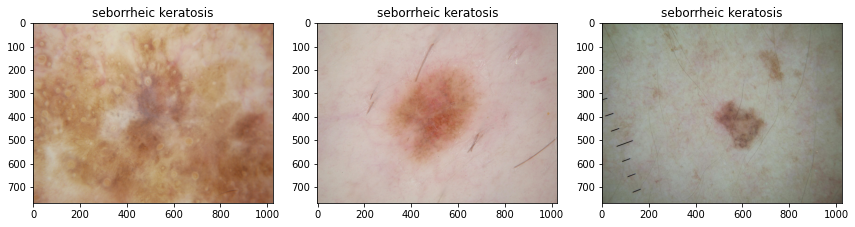

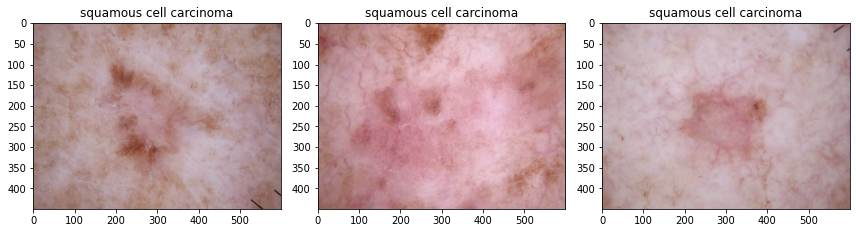

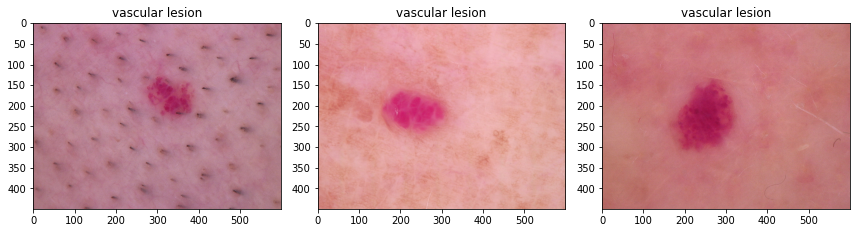

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

Dataset Balancer

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.1


Prepare X,y

In [ ]:
y = df['Labels']
X = df.drop('Labels', 1)

# summarize class distribution
from collections import Counter
counter = Counter(y)
print(counter)

Counter({'pigmented benign keratosis': 462, 'melanoma': 438, 'basal cell carcinoma': 376, 'nevus': 357, 'squamous cell carcinoma': 181, 'vascular lesion': 139, 'actinic keratosis': 114, 'dermatofibroma': 95, 'seborrheic keratosis': 77})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


Transform

In [ ]:
# input image size
IMAGE_W = 224
IMAGE_H = 224
IMG_SIZE = (IMAGE_W,IMAGE_H)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def SMOTE_Data(train_df=X):
    from imblearn.over_sampling import SMOTE
    X_train = []
    for img in train_df['FilePaths']:
        loaded_img = load_img(img, target_size=IMG_SIZE)
        img_arr = img_to_array(loaded_img)
        X_train.append(img_arr)
        
    print(np.array(X_train).shape)  
    y_train = y
    print(y_train.head())
    y_train = np.array(y_train.values)
    X_train = np.array(X_train)
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train.reshape((-1, IMAGE_W * IMAGE_H * 3)), y_train)
    X_train.reshape(-1, IMAGE_W, IMAGE_H, 3)
    return X_train, y_train

In [ ]:
print(X.shape)
print(y.shape)
X_train, y_train = SMOTE_Data()
print(X_train.shape)
print(y_train.shape)

(2239, 1)
(2239,)
(2239, 224, 224, 3)
0                melanoma
1    basal cell carcinoma
2         vascular lesion
3         vascular lesion
4                   nevus
Name: Labels, dtype: object
(4158, 150528)
(4158,)


In [ ]:
counter = Counter(y_train)
print(counter)

Counter({'melanoma': 462, 'basal cell carcinoma': 462, 'vascular lesion': 462, 'nevus': 462, 'pigmented benign keratosis': 462, 'squamous cell carcinoma': 462, 'seborrheic keratosis': 462, 'actinic keratosis': 462, 'dermatofibroma': 462})


In [ ]:
X_train = X_train.reshape(-1, IMAGE_W, IMAGE_H, 3)
print(X_train.shape)

(4158, 224, 224, 3)


In [ ]:
images = np.array(X_train)
label = np.array(y_train)
df = pd.DataFrame({'Labels': label, 'Images': list(images)}, columns=['Labels', 'Images'])

Split dataset to train and val

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (3326, 2)
Val Data:  (832, 2)


Create and compile the model

# ResNet Transfer Learning
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [ ]:
# count of epchos
EPOCHS = 100
# number of samples/images per iteration
BATCH_SIZE = 32

In [ ]:
X_train_arr = np.array(X_train.Images.tolist())
y_train_arr = np.array(X_train.Labels.tolist())
X_val_arr = np.array(X_val.Images.tolist())
y_val_arr = np.array(X_val.Labels.tolist())

In [ ]:
y_train_arr = y_train_arr.reshape(-1,1)
y_val_arr = y_val_arr.reshape(-1,1)

In [ ]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
y_train_arr= label_encoder.fit_transform(y_train_arr)
y_val_arr= label_encoder.fit_transform(y_val_arr)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: ignored

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
import numpy as np

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))
# create the base pre-trained model
base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
#predictions = Dense(9, activation='softmax')(x)
predictions = Dense(9)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# train the model on the new data for a few epochs
hst = model.fit(X_train_arr, y_train_arr, epochs=EPOCHS, validation_data=(X_val_arr, y_val_arr))

Epoch 1/100
104/104 [==============================] - 623s 6s/step - loss: 11.1916 - accuracy: 0.1182 - val_loss: 11.1556 - val_accuracy: 0.1154
Epoch 2/100
104/104 [==============================] - 618s 6s/step - loss: 11.1144 - accuracy: 0.1206 - val_loss: 11.0646 - val_accuracy: 0.1286
Epoch 3/100
 87/104 [========================>.....] - ETA: 1:21 - loss: 11.3649 - accuracy: 0.1164

KeyboardInterrupt: ignored

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [ ]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        "accuracy"
    ])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Load test data

In [ ]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [ ]:
X_test.head(3)

In [ ]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Preprocess test image

In [ ]:
# image preprocessing
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Evaluate model againts test data

In [ ]:
res = model.evaluate(X_test)

The accuracy

In [ ]:
# accuracy
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Calculate y_pred

In [ ]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Calculate y_true

In [ ]:
# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

The confusion metric

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.ticker import FuncFormatter
import textwrap as tw

In [ ]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(18,18))
# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0000', '#09AA00'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage' 
               linecolor='white',
               ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])